In this tutorial we are going to cover how to implement RBF for a sample dataset.<br>|
1. We are going to create our dataset based on a a circle function, x^2+y^2:
 - if it is <=1 then it is labeled as class 1
 - Else it is labeled as class 2


In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = []

def gen_func(x1, x2):
  if x1**2 + x2**2 <= 1:
    dataset.append([x1, x2, 1])
  else:
    dataset.append([x1, x2, -1])

a = [i for i in range(21)]
b = a.copy()

def gen_dataset():
  for i in a:
    for j in b:
      x1 = -2 + 0.2*i
      x2 = -2 + 0.2*j
      gen_func(round(x1, 3), round(x2, 3))

gen_dataset()

dataset = np.array(dataset)
print(dataset.shape)

(441, 3)


In [3]:
X = dataset[:, :2]
y = dataset[:, [2]]

print(X.shape, y.shape)

(441, 2) (441, 1)


Performance calculations

In [4]:
def calculate_acc(y_t, y_p):
    return (y_p == y_t).mean()

def calculate_mse(y_t, y_p):
    return np.mean((y_t - y_p)**2)


In [5]:

def get_optimal_spread(numCenters, centers):
    all_dist = []
    for c1 in centers:
        for c2 in centers:
            dist = np.linalg.norm(c1-c2)
            all_dist.append(dist)
            
    dmax = max(all_dist)

    sigma = dmax / (numCenters ** 0.5)
    print("Optimal spread : {}".format(sigma))
    
    return [0.5*sigma, sigma, 1.5*sigma, 2*sigma, 2.5*sigma, 3*sigma]

2. Create an RBF NN based on Guassian Kernel

In [6]:
# this is the implementation of the pseudo inverse based learning method.

class RBFv1:
    
    # inititalization function, numCenters is the number of Centers, centers if given, and spread of the function sigma.
    def __init__(self, inpdim, outpdim, numCenters, centers, spread = None):
        self.inpdim = inpdim
        self.outpdim = outpdim
        self.numCenters = numCenters
        
        #initialize random weight function
        self.W = np.random.random((self.numCenters, self.outpdim))
        
        #initialize random centers
        self.C = centers
        
        #calculate initial spread
        if spread is not None:
            self.sigma = spread
        else:
            # calculate and normalize spread
            all_dist = []
            for c1 in self.C:
                for c2 in self.C:
                    dist = np.linalg.norm(c1-c2)
                    all_dist.append(dist)
            dmax = max(all_dist)

            self.sigma = dmax / (self.numCenters ** 0.5)
    
    # gaussian basis function
    def _gaussBasisFunc(self, center, x):
        return np.exp(-((np.linalg.norm(x-center)**2) / 2*(self.sigma**2)))
    
    # function for calculating activation
    def _calculateActivation(self, X):
        # create the matrix of activations.
        # First initialize with zeros
        # Activation matrix will have dimension (number of rows in train * num_centers)
        G = np.zeros((X.shape[0], self.numCenters), float)
        
        # loop over all the centers and inputs
        for center_index, center in enumerate(self.C):
            for x_index, x in enumerate(X):

                # calculate activations and store in appropriate (input, center) cell
                G[x_index, center_index] = self._gaussBasisFunc(center, x)
        
        return G
                
    
    # function for training
    def fit(self, X, y):
        
        # calculating the activations for input data
        G = self._calculateActivation(X)
        
        # Calculate the weights
        self.W = np.dot(np.linalg.pinv(G), y)
        
        return self
    

    # function for testing
    def predict(self, X):

        # do the forward pass : calculate activations and dot product with weights to get output
        G = self._calculateActivation(X)
        output = np.dot(G, self.W)
        
        # output can only be -1 or +1
        for idout, out in enumerate(output):
          if out < 0:
            output[idout] = -1
          elif out > 0:
            output[idout] = +1

        return output

3. Testing the code

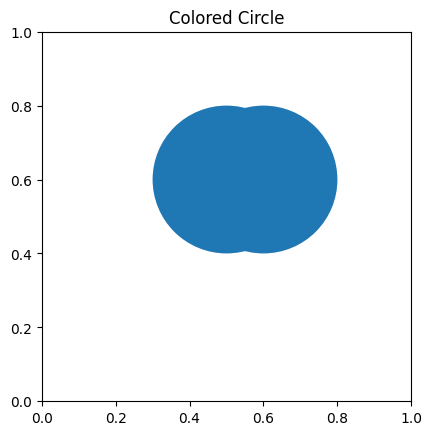

In [7]:

figure, axes = plt.subplots()
Drawing_colored_circle = plt.Circle(( 0.6 , 0.6 ), 0.2 )

axes.set_aspect( 1 )
axes.add_artist( Drawing_colored_circle )
axes.add_artist( plt.Circle(( 0.5, 0.6 ), 0.2 ) )

plt.title( 'Colored Circle' )
plt.show()

In [8]:
# using 80-20 train-test splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

print(X_train.shape)


# will compare performance over multiple spread values
sigma_grid_model1 = get_optimal_spread(X_train.shape[0], X_train)

test_mse_grid_model1 = []
test_acc_grid_model1 = []
train_mse_grid_model1 = []
train_acc_grid_model1 = []

for sigma in sigma_grid_model1:
    print("Training for sigma : {}".format(sigma))
    model1 = RBFv1(inpdim=2, outpdim=1, numCenters=X_train.shape[0], centers=X_train, spread=sigma)
    model1.fit(X_train, y_train)
    y_pred_model1 = model1.predict(X_test)
    
    y_train_pred_model1 = model1.predict(X_train)

    test_acc = calculate_acc(y_test, y_pred_model1)
    test_mse = calculate_mse(y_test, y_pred_model1)
    
    train_acc = calculate_acc(y_train, y_train_pred_model1)
    train_mse = calculate_mse(y_train, y_train_pred_model1)
    
    test_mse_grid_model1.append(test_mse)
    test_acc_grid_model1.append(test_acc)
    train_mse_grid_model1.append(train_mse)
    train_acc_grid_model1.append(train_acc)
    
    print("Training Accuracy : {} - Training MSE : {}".format(train_acc, train_mse))
    print("Test Accuracy : {} - Test MSE : {}".format(test_acc, test_mse))

(352, 2)
Optimal spread : 0.2940701833360069
Training for sigma : 0.14703509166800344
Training Accuracy : 0.9772727272727273 - Training MSE : 0.09090909090909091
Test Accuracy : 0.9662921348314607 - Test MSE : 0.1348314606741573
Training for sigma : 0.2940701833360069
Training Accuracy : 0.9886363636363636 - Training MSE : 0.045454545454545456
Test Accuracy : 0.9775280898876404 - Test MSE : 0.0898876404494382
Training for sigma : 0.4411052750040103
Training Accuracy : 0.9943181818181818 - Training MSE : 0.022727272727272728
Test Accuracy : 0.9775280898876404 - Test MSE : 0.0898876404494382
Training for sigma : 0.5881403666720137
Training Accuracy : 0.9943181818181818 - Training MSE : 0.022727272727272728
Test Accuracy : 0.9775280898876404 - Test MSE : 0.0898876404494382
Training for sigma : 0.7351754583400172
Training Accuracy : 0.9943181818181818 - Training MSE : 0.022727272727272728
Test Accuracy : 0.9325842696629213 - Test MSE : 0.2696629213483146
Training for sigma : 0.882210550008

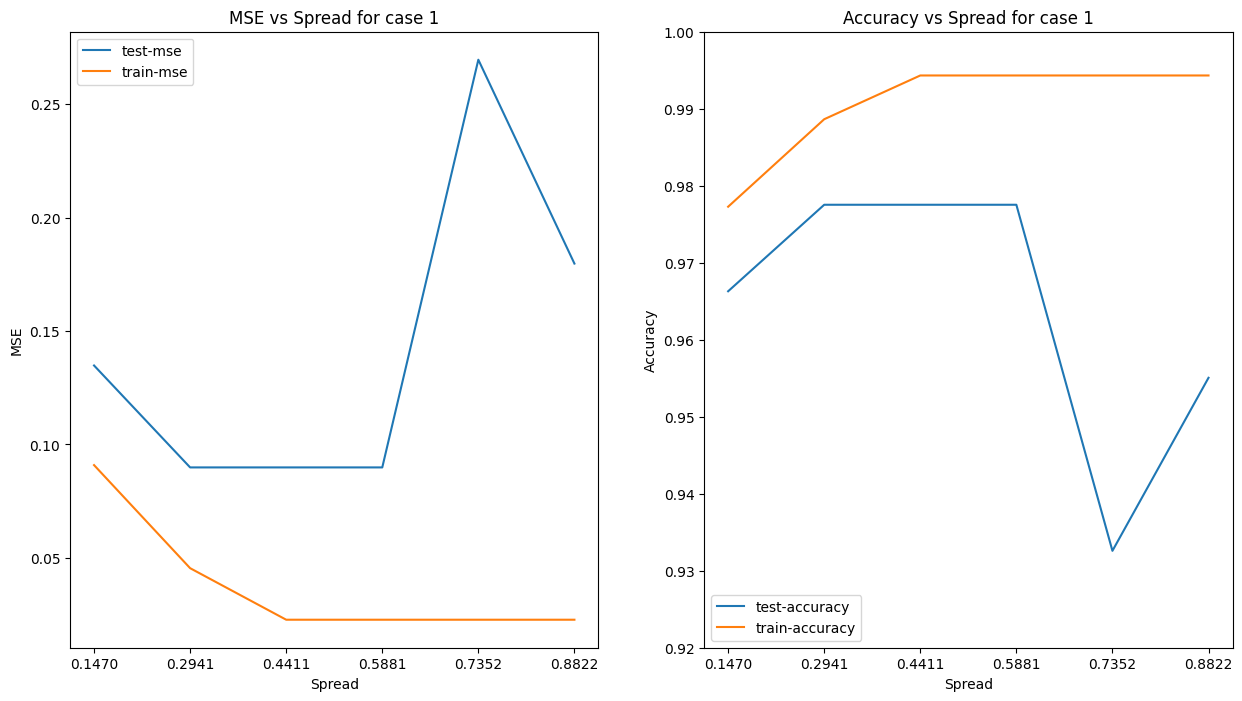

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(sigma_grid_model1, test_mse_grid_model1, label="test-mse")
plt.plot(sigma_grid_model1, train_mse_grid_model1, label="train-mse")
plt.xticks(sigma_grid_model1)
plt.xlabel("Spread")
plt.ylabel("MSE")
plt.legend(loc="upper left")
plt.title("MSE vs Spread for case 1")

plt.subplot(1,2,2)
plt.plot(sigma_grid_model1, test_acc_grid_model1, label='test-accuracy')
plt.plot(sigma_grid_model1, train_acc_grid_model1, label='train-accuracy')
plt.xticks(sigma_grid_model1)
plt.xlabel("Spread")
plt.ylabel("Accuracy")
plt.ylim(0.92, 1.0)
plt.legend(loc="lower left")
plt.title("Accuracy vs Spread for case 1")

plt.show()